In [1]:
from collections import Counter

from pymatgen import Structure, Lattice
from tqdm import tqdm
import multiprocessing

import numpy as np
import yaml

from polyhedral_analysis.trajectory import Trajectory
from polyhedral_analysis.polyhedra_recipe import PolyhedraRecipe, create_matching_site_generator

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [2]:
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Iowan Old Style']
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams.update({'font.size': 20})
rcParams['mathtext.fontset'] = 'dejavuserif'

In [3]:
with open('../md_runs.yaml') as f:
    md_data = yaml.safe_load(f)
print(md_data)

{'Li6PS5I': {'0p': [1, 2, 3, 4, 5, 6], '50p': [1, 2, 3, 4, 5, 6, 7], '100p': [1, 2, 3, 4, 5, 6, 7]}, 'Li6PS5Cl': {'0p': [1, 2, 3, 4, 5], '50p': [1, 2, 3, 4, 5, 6], '100p': [1, 2, 3, 4, 5, 6]}}


In [4]:
# Create reference structures containing ideal 4c and 4a sites in 2x2x2 supercells.

## define a 2x2x2 cell of 4c sites
coords_4c = np.array( [ [ 0.25, 0.25, 0.75 ],
                        [ 0.75, 0.25, 0.25 ],
                        [ 0.25, 0.75, 0.25 ],
                        [ 0.75, 0.75, 0.75 ] ] )
atom_list = [ 'S' ] * len( coords_4c )
lattice = Lattice.from_parameters( a=3.0, b=3.0, c=3.0, alpha=90, beta=90, gamma=90 )
structure = Structure( lattice, atom_list, coords_4c )
reference_structure_4c = structure * [ 2, 2, 2 ]

## define a 2x2x2 cell of 4a sites
coords_4a = np.array( [ [ 0.0, 0.0, 0.0 ],
                        [ 0.5, 0.5, 0.0 ],
                        [ 0.0, 0.5, 0.5 ],
                        [ 0.5, 0.0, 0.5 ] ] )
atom_list = [ 'S' ] * len( coords_4a )
lattice = Lattice.from_parameters( a=3.0, b=3.0, c=3.0, alpha=90, beta=90, gamma=90 )
structure = Structure( lattice, atom_list, coords_4a )
reference_structure_4a = structure * [ 2, 2, 2 ]

reference_structures = { '4c': reference_structure_4c, 
                         '4a': reference_structure_4a }

s_4c_matching_sites = create_matching_site_generator( reference_structure=reference_structure_4c, species=['S'] )
s_4a_matching_sites = create_matching_site_generator( reference_structure=reference_structure_4a, species=['S'] )

In [5]:
polyhedral_params = {'Li6PS5I': 
                        {'0p': 
                            {'coordination_cutoff': 2.6,
                             'vertex_graph_cutoff': 4.1 }
                        }
                    }
                      
lithium_indices = list(range(192))

In [6]:
def build_poly_recipes(coordination_cutoff, vertex_graph_cutoff):
    poly_recipes = [PolyhedraRecipe(method='distance cutoff',
                                    coordination_cutoff=coordination_cutoff,  
                                    vertex_graph_cutoff=vertex_graph_cutoff, 
                                    central_atoms=s_4c_matching_sites, 
                                    vertex_atoms=lithium_indices,
                                    label='4c'),
                    PolyhedraRecipe(method='distance cutoff',
                                    coordination_cutoff=coordination_cutoff,  
                                    vertex_graph_cutoff=vertex_graph_cutoff, 
                                    central_atoms=s_4a_matching_sites, 
                                    vertex_atoms=lithium_indices,
                                    label='4a')]
    return poly_recipes

In [7]:
ncores = 8
data_dir = '../../data'
trajectory_data = {}
# for system in md_data:
system = 'Li6PS5I'
disorder = '0p'
trajectory_data[system] = {}
runs = md_data[system][disorder]
xdatcars = [f'{data_dir}/{system}/{disorder}/run{i}/inherent_XDATCAR.gz' for i in runs]
print(f'Reading {system}/{disorder} XDATCARs')
poly_recipes = build_poly_recipes(**polyhedral_params[system][disorder])
trajectory_data[system][disorder] = Trajectory.from_xdatcars(filenames=xdatcars, 
                                                             recipes=poly_recipes, 
                                                             ncores=ncores, 
                                                             progress=True)

Reading Li6PS5I/0p XDATCARs


100%|██████████| 700/700 [07:29<00:00,  1.56 configurations/s]


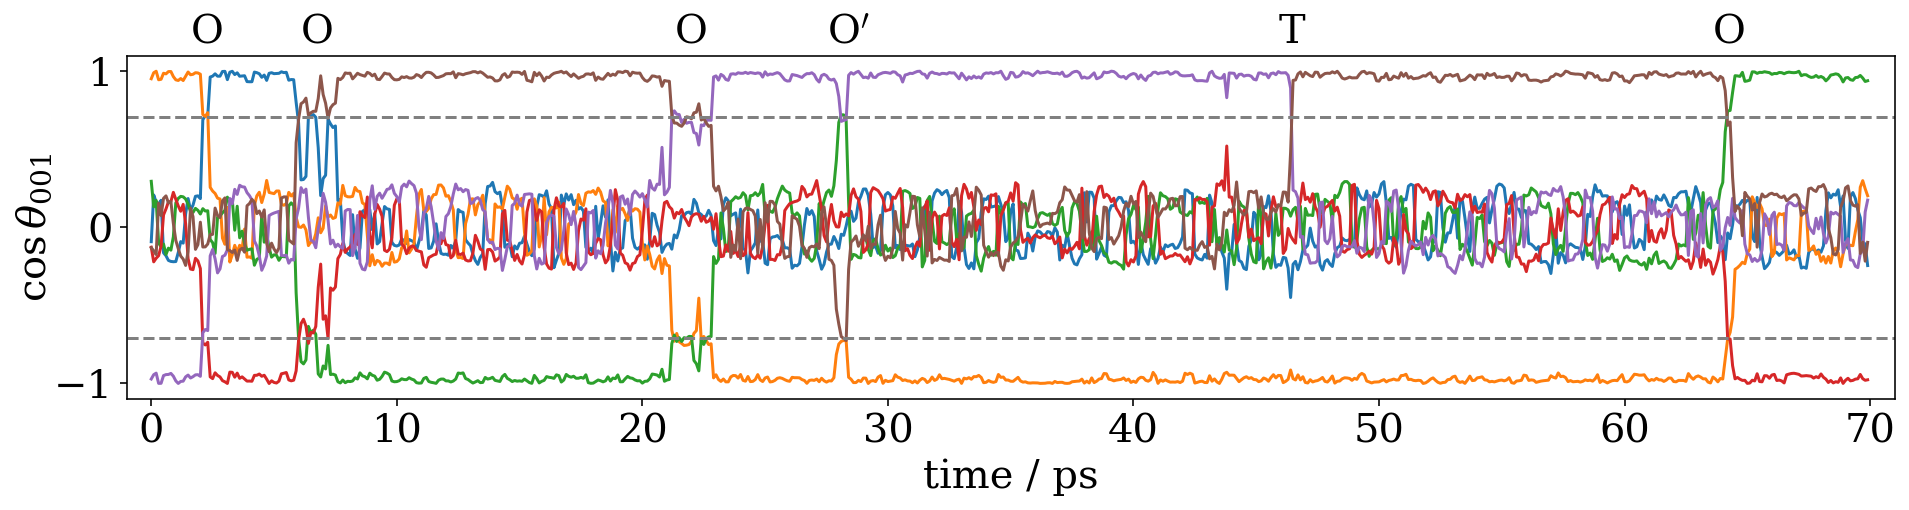

In [8]:
# Plot example polyhedral orientation dynamics for a single SLi_6 coordination polyhedron
# from the Li6PS5I 0% site-inverted simulation
trajectory = trajectory_data['Li6PS5I']['0p']
dt = np.arange(len(trajectory))/10.0

pn = 3

projections_001 = []
projections_010 = []
projections_100 = []
for c in trajectory.configurations:
    polyhedron = c.polyhedra[pn]
    projections_001.append(polyhedron.vertex_vector_projections(np.array([0.0, 0.0, 1.0])))
    projections_010.append(polyhedron.vertex_vector_projections(np.array([0.0, 1.0, 0.0])))
    projections_100.append(polyhedron.vertex_vector_projections(np.array([1.0, 0.0, 0.0])))
projections_001 = np.hstack(projections_001)
projections_010 = np.hstack(projections_010)
projections_100 = np.hstack(projections_100)

plt.figure(figsize=(14,4))
for proj in projections_001: # plot each S--Li vector projection onto [001]
    plt.plot(dt,proj)
# axis labels
plt.xlabel('time / ps')
plt.ylabel(r'$\cos\,\theta_{001}$', labelpad=0)

plt.xlim([-1,71])

# Add labels for dynamic events
for x in [1.6, 6.1, 21.3, 63.6]: # octahedral rotations
    plt.text(x,1.18, 'O')
for x in [27.5]:
    plt.text(x,1.18, 'O$^\prime$') # incomplete octahedral rotations
for x in [45.9]:
    plt.text(x,1.18, 'T') # trigonal-prismatic reorganistations
    
# Add guide lines for 45 degree rotations 
plt.plot([-1.0, 71.0],[np.sqrt(2)/2, np.sqrt(2)/2], '--', color='grey')
plt.plot([-1.0, 71.0],[-np.sqrt(2)/2, -np.sqrt(2)/2], '--', color='grey')

plt.tight_layout()
plt.savefig('../../figures/Li6PS5I_octahedral_projection.pdf')

plt.show()

In [9]:
%load_ext version_information

%version_information yaml, pymatgen, tqdm, numpy, polyhedral_analysis, matplotlib

Software versions
Python 3.7.7 64bit [Clang 11.0.3 (clang-1103.0.32.62)]
IPython 7.19.0
OS Darwin 19.6.0 x86_64 i386 64bit
yaml 5.3.1
pymatgen 2020.11.11
tqdm 4.54.0
numpy 1.19.4
polyhedral_analysis 0.1
matplotlib 3.3.3
Wed Dec 09 09:18:05 2020 GMT